In [1]:
# This notebook uses the lemmatized document data and information to create .csv files of the total number of papers
# published on arxiv for different fields in AI Alignment. These trends are then plotted and saved to create the figures
# seen in the blog post. Please read the blog post for further details.
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
from datetime import datetime, date, timedelta
import pandas as pd
from lmfit import Model

In [2]:
def linear(x, m, x0, c):
    """A linear function used for fitting."""
    return m*(x - x0) + c 

In [3]:
def exponential(x, k1, m, c):
    """An exponential function used for fitting."""
    return k1*(10**(m*x + c))

In [4]:
def generate_plot_info(papers,info_dict):
    """Function to generate datewise information required for trend plotting. Converts document-based grouping to date-based grouping"""
    paper_info = {}

    for i in papers:
        paper_info.update({i : {'author_count' : len(info_dict[i]['authors']), 'date' : date(int('20' + info_dict[i]['url'][21:23]), int(info_dict[i]['url'][23:25]), 1)}})
    
    # date_info stores the total number of papers published and unique authors in the field for each date value
    date_info = {}
    
    for i in paper_info.keys():
        if paper_info[i]['date'] not in date_info.keys():
            # pcount -> Number of papers & acount -> Number of authors
            date_info.update({paper_info[i]['date'] : {'pcount' : 0, 'acount' : 0}})
    
    authors_added = []        
    for i in paper_info.keys():
        new_auth = 0
        for j in info_dict[i]['authors']:
            if j not in authors_added:
                authors_added.append(j)
                new_auth = new_auth + 1
        date_info[paper_info[i]['date']]['pcount'] = date_info[paper_info[i]['date']]['pcount'] + 1
        date_info[paper_info[i]['date']]['acount'] = date_info[paper_info[i]['date']]['acount'] + new_auth

    dates = list(date_info.keys())
    dates.sort()

    # date_info is converted to an array called plot_info -> [date, paper count, author count], for easier working with pandas dataframes
    plot_info = [[dates[0], date_info[dates[0]]['pcount'], date_info[dates[0]]['acount']]]

    for i in range(1,len(dates)):
        plot_info.append([dates[i],plot_info[i-1][1] + date_info[dates[i]]['pcount'], plot_info[i-1][2] + date_info[dates[i]]['acount']])

    return plot_info

In [5]:
lemma_file = 'lemma_dict.pkl'
info_file = 'info_dict.pkl'

# Loading data files using their names
lemmapath = Path(lemma_file)
infopath = Path(info_file)

if lemmapath.is_file:
    with open(lemma_file,'rb') as fname:
        lemma_dict = pickle.load(fname)
if infopath.is_file:
    with open(info_file,'rb') as fname:
        info_dict = pickle.load(fname)

print("Total Number of Papers: ", len(lemma_dict))

Total Number of Papers:  959


In [6]:
# Papers and authors in AI Interpretability selected by checking the appearance of relevant lemmas in documents
int_papers = []
for i in lemma_dict.keys():
    if ('interpretability' in lemma_dict[i] or 'interpretable' in lemma_dict[i]):
        int_papers.append(i)

int_authors = []
for i in int_papers:
    for j in info_dict[i]['authors']:
        if j not in int_authors:
            int_authors.append(j)

# Papers and authors in AI Policy and Governance selected by checking the appearance of relevant lemmas in documents
pol_papers = []
for i in lemma_dict.keys():
    if ('policy' in lemma_dict[i] or 'governance' in lemma_dict[i]):
        pol_papers.append(i)

pol_authors = []
for i in pol_papers:
    for j in info_dict[i]['authors']:
        if j not in pol_authors:
            pol_authors.append(j)

# All papers and authors in AI alignment added to separate lists           
all_papers = list(lemma_dict.keys())

all_authors = []
for i in all_papers:
    for j in info_dict[i]['authors']:
        if j not in all_authors:
            all_authors.append(j)

# Used for .csv creation and plotting purposes 
paperlist = {'Interpretability' : {'papers' : int_papers, 'color' : 'blue'}, 'Policy' : {'papers' : pol_papers, 'color' : 'orange'}, 'Alignment' : {'papers' : all_papers, 'color' : 'pink'}}

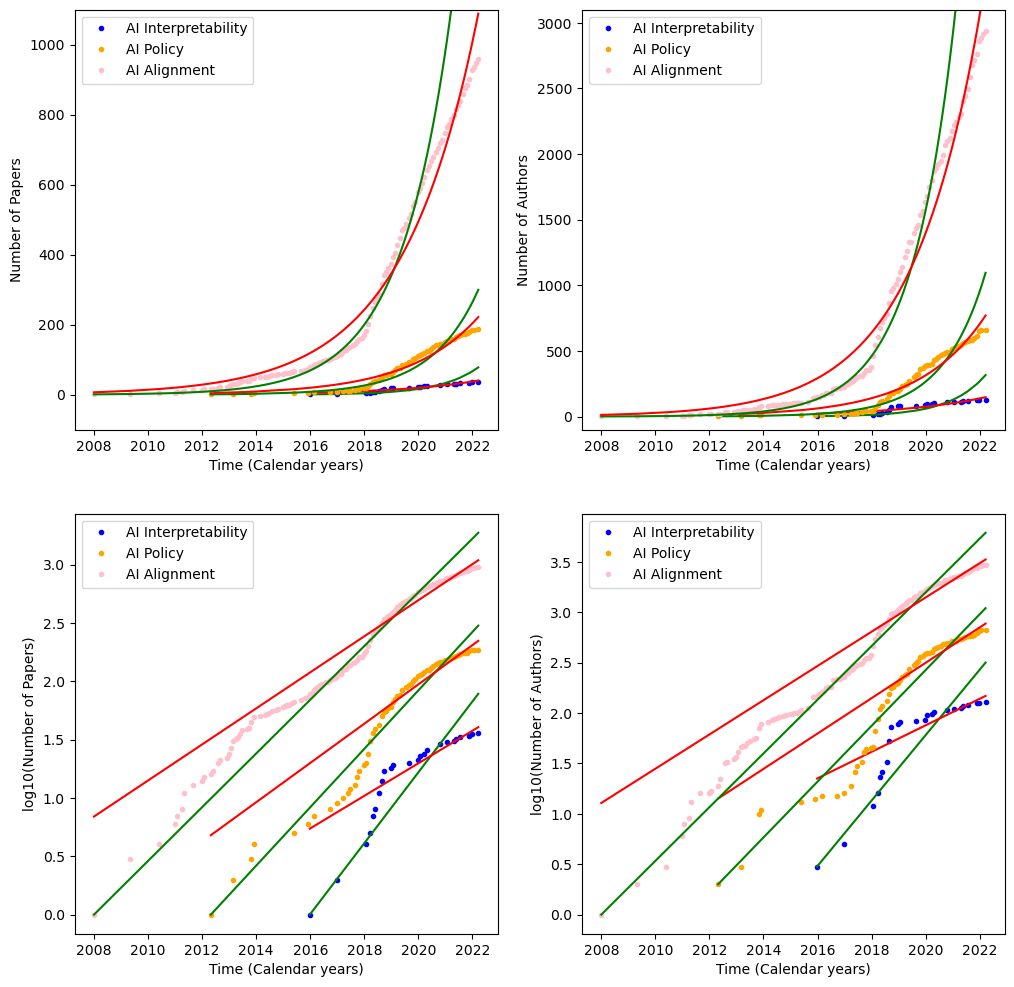

In [7]:
# Creating .csv files and plots for each field in paperlist
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
for name in paperlist.keys(): 
    
    plot_info = generate_plot_info(paperlist[name]['papers'], info_dict)
    df = pd.DataFrame(plot_info, columns =['Date', 'Papers', 'Authors'])
    
    df['cDays'] = [(df['Date'][i] - date(2008, 2, 1)).days for i in range(0, len(df))]
    
    # Fitting a linear model to y = log10(Number of papers/authors) vs x = Number of days since first paper in AI Alignment was published
    modelL = Model(linear)
    
    paramsLP = modelL.make_params(m=0.5, x0=(df['Date'][0] - date(2008,2,1)).days, c=np.log10(df['Papers'][0]))
    paramsLP['x0'].vary = False
    paramsLP['c'].vary = False 
    resultLP = modelL.fit(np.log10(df['Papers']), paramsLP, x=df['cDays'])
    
    paramsLA = modelL.make_params(m=0.5, x0=(df['Date'][0] - date(2008,2,1)).days, c=np.log10(df['Authors'][0]))
    paramsLA['x0'].vary = False
    paramsLA['c'].vary = False 
    resultLA = modelL.fit(np.log10(df['Authors']), paramsLA, x=df['cDays'])
    
    # Fitting an exponential model to y = Number of papers/authors vs x = Number of days since first paper in AI Alignment was published
    modelE = Model(exponential)
    
    paramsEP = modelE.make_params(k1=1, m=0.0001, c=1)  
    resultEP = modelE.fit(df['Papers'], paramsEP, x=df['cDays'])
    
    paramsEA = modelE.make_params(k1=1, m=0.0001, c=1)
    resultEA = modelE.fit(df['Authors'], paramsEA, x=df['cDays'])
    
    # Plotting data points and fit lines
    ax[0][0].plot(df['cDays'], df['Papers'], '.', color=paperlist[name]['color'], label="AI "+str(name))
    ax[0][1].plot(df['cDays'], df['Authors'], '.', color=paperlist[name]['color'], label="AI "+str(name))
    ax[0][0].plot(df['cDays'], 10**(linear(df['cDays'], resultLP.params['m'].value, resultLP.params['x0'].value, resultLP.params['c'].value)), color='green')
    ax[0][1].plot(df['cDays'], 10**(linear(df['cDays'], resultLA.params['m'].value, resultLA.params['x0'].value, resultLA.params['c'].value)), color='green')
    ax[0][0].plot(df['cDays'], exponential(df['cDays'], resultEP.params['k1'].value, resultEP.params['m'].value, resultEP.params['c'].value), color='red')
    ax[0][1].plot(df['cDays'], exponential(df['cDays'], resultEA.params['k1'].value, resultEA.params['m'].value, resultEA.params['c'].value), color='red')
    
    ax[1][0].plot(df['cDays'], np.log10(df['Papers']), '.', color=paperlist[name]['color'], label="AI "+str(name))
    ax[1][1].plot(df['cDays'], np.log10(df['Authors']), '.', color=paperlist[name]['color'], label="AI "+str(name))
    ax[1][0].plot(df['cDays'], linear(df['cDays'], resultLP.params['m'].value, resultLP.params['x0'].value, resultLP.params['c'].value), color='green')
    ax[1][1].plot(df['cDays'], linear(df['cDays'], resultLA.params['m'].value, resultLA.params['x0'].value, resultLA.params['c'].value), color='green')
    ax[1][0].plot(df['cDays'], np.log10(exponential(df['cDays'], resultEP.params['k1'].value, resultEP.params['m'].value, resultEP.params['c'].value)), color='red')
    ax[1][1].plot(df['cDays'], np.log10(exponential(df['cDays'], resultEA.params['k1'].value, resultEA.params['m'].value, resultEA.params['c'].value)), color='red')
    
    xticks = [0, 366*2, 366*4, 366*6, 366*8, 366*10, 366*12, 366*14]
    ax[0][0].set_xlabel("Time (Calendar years)")
    ax[0][0].set_ylabel("Number of Papers")
    ax[0][0].set_xticks(xticks)
    ax[0][0].set_xticklabels([(date(2008, 2, 1) + pd.to_timedelta(i, unit='d')).strftime("%Y") for i in xticks])
    ax[0][0].legend()
    ax[0][0].set_ylim(-100,1100)
    ax[0][1].set_xlabel("Time (Calendar years)")
    ax[0][1].set_ylabel("Number of Authors")
    ax[0][1].legend()
    ax[0][1].set_xticks(xticks)
    ax[0][1].set_xticklabels([(date(2008, 2, 1) + pd.to_timedelta(i, unit='d')).strftime("%Y") for i in xticks])
    ax[0][1].set_ylim(-100,3100)
    ax[1][0].set_xlabel("Time (Calendar years)")
    ax[1][0].set_ylabel("log10(Number of Papers)")
    ax[1][0].legend()
    ax[1][0].set_xticks(xticks)
    ax[1][0].set_xticklabels([(date(2008, 2, 1) + pd.to_timedelta(i, unit='d')).strftime("%Y") for i in xticks])
    ax[1][1].set_xlabel("Time (Calendar years)")
    ax[1][1].set_ylabel("log10(Number of Authors)")
    ax[1][1].legend()
    ax[1][1].set_xticks(xticks)
    ax[1][1].set_xticklabels([(date(2008, 2, 1) + pd.to_timedelta(i, unit='d')).strftime("%Y") for i in xticks])
    
    # Saving field specific dataframes to .csv files, dates will not show up properly in Excel, but the .csv can be loaded and used as seen in the next cell
    df['Date'] = df['Date'].astype('datetime64[ns]')
    df.to_csv(name+".csv", index=False, date_format='%Y-%m-%d')

plt.savefig("Field_Comparison.png")
plt.show()

Standard Deviation for number of papers:  3.5758594755741355
Standard Deviation for number of authors:  17.531087186211437


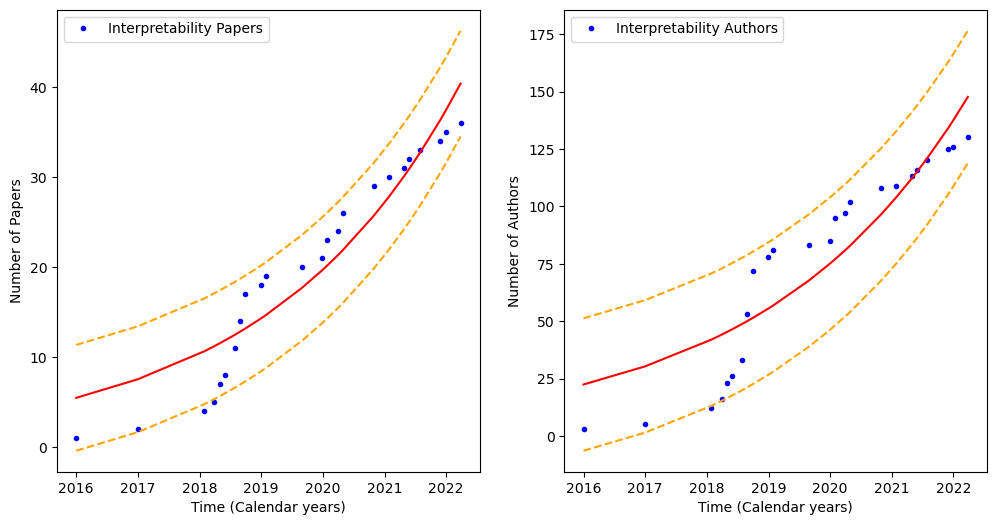

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Load previously created .csv file for AI Interpretability
df = pd.read_csv('Interpretability.csv')
df['cDays'] = df['cDays'] - df['cDays'][0]

# Fitting an exponential model to y = Number of papers/authors vs x = Number of days since first paper in AI Alignment was published
modelE = Model(exponential)

paramsEP = modelE.make_params(k1=1, m=0.0001, c=1)  
resultEP = modelE.fit(df['Papers'], paramsEP, x=df['cDays'])

paramsEA = modelE.make_params(k1=1, m=0.0001, c=1)
resultEA = modelE.fit(df['Authors'], paramsEA, x=df['cDays'])

# Caculating standard deviation for fits to Number of papers/authors
sq_errorP = 0.0
sq_errorA = 0.0
for i in range(0,len(df)):
    sq_errorP = sq_errorP + (df['Papers'][i] - exponential(df['cDays'][i], resultEP.params['k1'].value, resultEP.params['m'].value, resultEP.params['c'].value))**2 
    sq_errorA = sq_errorA + (df['Authors'][i] - exponential(df['cDays'][i], resultEA.params['k1'].value, resultEA.params['m'].value, resultEA.params['c'].value))**2 

stdP = (sq_errorP/len(df))**0.5
stdA = (sq_errorA/len(df))**0.5
print("Standard Deviation for number of papers: ", str(stdP))
print("Standard Deviation for number of authors: ", str(stdA))

# Calculating 90% confidence intervals
conf90P = 1.645*stdP
conf90A = 1.645*stdA

# Plotting data (blue), fit lines (red) and confidence intervals (orange)
ax[0].plot(df['cDays'], df['Papers'], '.', color=paperlist['Interpretability']['color'], label='Interpretability Papers')
ax[1].plot(df['cDays'], df['Authors'], '.', color=paperlist['Interpretability']['color'], label='Interpretability Authors')

ax[0].plot(df['cDays'], exponential(df['cDays'], resultEP.params['k1'].value, resultEP.params['m'].value, resultEP.params['c'].value), color='red')
ax[1].plot(df['cDays'], exponential(df['cDays'], resultEA.params['k1'].value, resultEA.params['m'].value, resultEA.params['c'].value), color='red')

ax[0].plot(df['cDays'], exponential(df['cDays'], resultEP.params['k1'].value, resultEP.params['m'].value, resultEP.params['c'].value) + conf90P, color='orange', linestyle='--')
ax[0].plot(df['cDays'], exponential(df['cDays'], resultEP.params['k1'].value, resultEP.params['m'].value, resultEP.params['c'].value) - conf90P, color='orange', linestyle='--')
ax[1].plot(df['cDays'], exponential(df['cDays'], resultEA.params['k1'].value, resultEA.params['m'].value, resultEA.params['c'].value) + conf90A, color='orange', linestyle='--')
ax[1].plot(df['cDays'], exponential(df['cDays'], resultEA.params['k1'].value, resultEA.params['m'].value, resultEA.params['c'].value) - conf90A, color='orange', linestyle='--')

xticks = [0,366,366*2,366*3,366*4,366*5,366*6]
ax[0].set_xlabel("Time (Calendar years)")
ax[0].set_ylabel("Number of Papers")
ax[0].set_xticks(xticks)
ax[0].set_xticklabels([(datetime.strptime(df['Date'][0], "%Y-%m-%d") + pd.to_timedelta(i, unit='d')).strftime("%Y") for i in xticks])
ax[0].legend()
ax[1].set_xlabel("Time (Calendar years)")
ax[1].set_ylabel("Number of Authors")
ax[1].set_xticks(xticks)
ax[1].set_xticklabels([(datetime.strptime(df['Date'][0], "%Y-%m-%d") + pd.to_timedelta(i, unit='d')).strftime("%Y") for i in xticks])
ax[1].legend()

plt.savefig("Interpretability.png")
plt.show()